In [1]:
import matplotlib.pyplot as plt
import numpy as np

from nuscenes.nuscenes import NuScenes
from nuscenes.map_expansion.map_api import NuScenesMap
from nuscenes.can_bus.can_bus_api import NuScenesCanBus

dataroot='/data/Datasets/nuscenes'

nusc = NuScenes(version='v1.0-trainval', dataroot=dataroot, verbose=True)
nusc_map = NuScenesMap(dataroot=dataroot, map_name='singapore-onenorth')
nusc_can = NuScenesCanBus(dataroot=dataroot)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 34.665 seconds.
Reverse indexing ...
Done reverse indexing in 9.0 seconds.


In [54]:
#selecting the features we want to use from the CAN data
#scene_name = 'scene-0061'
scene_name = 'scene-0061'
feature_names = ['steering', 'vehicle_speed', 'utime']
raw_data = nusc_can.get_messages(scene_name, 'vehicle_monitor')
data = [{k: i[k] for k in feature_names} for i in raw_data]

#convert to seconds
start_utime = data[0]['utime']
for d in data:
    d['time'] = (d['utime'] - start_utime) * 1e-6
    del d['utime']


In [61]:
straight_threshhold = 20 # degree deadband for driving straight
coast_threshhold = 0.5 # km/h deadband for driving at constant speed
stop_threshhold = 0.05 #km/h threshhold for being stopped

# actually segment actions
actions = []
def change_action(action, time):
    if not actions or actions[len(actions)-1]['label'] != action:
        actions.append({'label':action, 'time':time})


last_speed = data[0]['vehicle_speed']
for d in data:
    action = 'none'
    speed = d['vehicle_speed']
    steer = d['steering']
    time = d['time']
    
    acceleration = speed - last_speed

    if speed < stop_threshhold:
        action = 'stop'
    else:
        if abs(steer) < straight_threshhold:
            if abs(acceleration) < coast_threshhold:
                action = 'drive straight'
            elif acceleration > 0:
                action = 'accelerate'
            elif acceleration < 0:
                action = 'decelerate'
        elif steer > 0:
            action = 'turn left'
        elif steer < 0:
            action = 'turn right'
    
    last_speed = speed

    change_action(action, time)

actions

[{'label': 'drive straight', 'time': 0.0},
 {'label': 'decelerate', 'time': 0.499359},
 {'label': 'turn left', 'time': 4.999527},
 {'label': 'drive straight', 'time': 14.498812},
 {'label': 'turn left', 'time': 16.499553}]

[(0.0, 0.499359, 'blue'), (0.499359, 4.999527, 'yellow'), (4.999527, 14.498812, 'orange'), (14.498812, 16.499553, 'blue'), (16.499553, 18.99926, 'orange')]


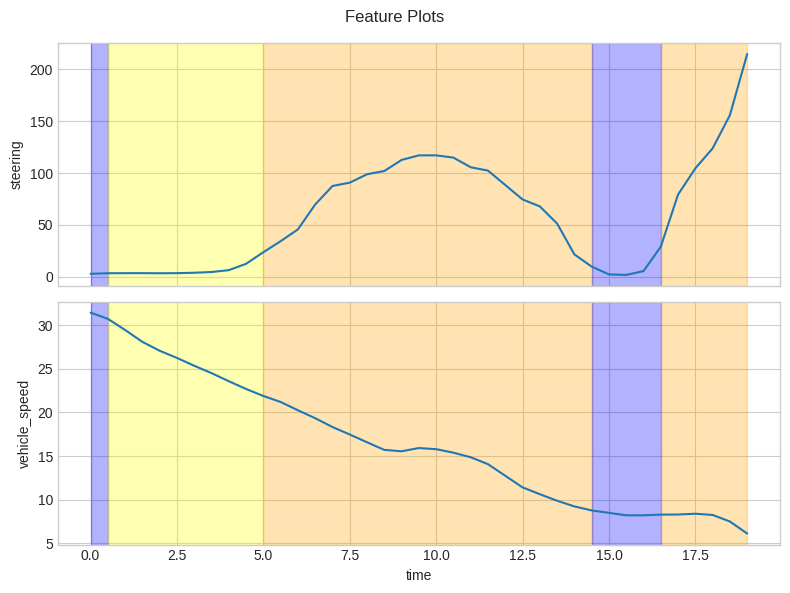

In [73]:
# PLOTTING

# create action period
colors = {'stop':'red', 'drive straight':'blue', 'accelerate':'green', 'decelerate':'yellow', 'turn left':'orange', 'turn right':'magenta'}
periods = []
for i in range(len(actions)):
    from_time = actions[i]['time']
    if i == len(actions)-1:
        to_time = data[len(data)-1]['time']
    else:
        to_time = actions[i+1]['time']
    color = colors[actions[i]['label']]
    periods.append((from_time, to_time, color))
print(periods)

xlabel = 'time'

# Extract unique feature keys
feature_keys = list(set().union(*(d.keys() for d in data)))
feature_keys.remove(xlabel)  # Remove 'timestamp' key

# Create a figure with subplots
num_subplots = len(feature_keys)
fig, axs = plt.subplots(num_subplots, 1, figsize=(8, 3 * num_subplots), sharex=True)

# Plot each feature in a separate subplot
for i, feature in enumerate(feature_keys):
    x = [d[xlabel] for d in data]
    feature_values = [d[feature] for d in data]
    
    if num_subplots == 1:
        ax = axs
    else:
        ax = axs[i]

    for start, end, color in periods:
        ax.axvspan(start, end, alpha=0.3, color=color)

    ax.plot(x, feature_values)
    ax.set_ylabel(feature)

# Set x-axis label and title
axs[-1].set_xlabel(xlabel)
fig.suptitle('Feature Plots')

plt.tight_layout()
plt.show()